## Graphical causal models and structural equation modeling

We are starting our discussion of SEM with a discussion of graphical causal models. This is a relatively new approach to thinking about SEM; for a detailed description of this approach and its relation to the standard way of conceptualizing SEM, see the 4th edition of Rex Kline's outstanding book, [Principles and practice of structural equation modeling](https://www.guilford.com/books/Principles-and-Practice-of-Structural-Equation-Modeling/Rex-Kline/9781462523344).  The presentation here is built around that book, along with papers from [Judea Pearl](http://bayes.cs.ucla.edu/jp_home.html) and his colleagues and the excellent introduction by [Glymour, 2006](https://publicifsv.sund.ku.dk/~nk/epiF14/Glymour_DAGs.pdf); I have tried to atttribute all direct quotes but there are some sections that are basically patch-written from those resources, so if you see something here that looks intelligent, please assume that one of those other authors is responsible for it.  Misunderstandings or errors should of course be attributed to me only.  

If you want a deep dive into the ideas behind much of this work, I would recommend Pearl's book [Causality (2nd Ed.)](http://bayes.cs.ucla.edu/BOOK-2K)

In [227]:
import numpy as np
import pandas as pd
import networkx as nx

# install using: pip install git+https://github.com/ijmbarr/causalgraphicalmodels
import causalgraphicalmodels
from causalgraphicalmodels import CausalGraphicalModel
%load_ext rpy2.ipython

/Users/poldrack/anaconda3/envs/py37/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


Graphical causal models provide a way to encode and visualize our assumptions about the causal structure that relates a set of variables.  Let's look at a simple example, which describes the various factors that relate to a sidewalk being slippery.  First, we show the graph:

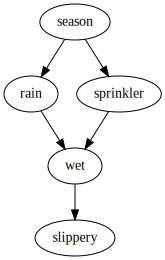

In [5]:
# from http://www.degeneratestate.org/posts/2018/Jul/10/causal-inference-with-python-part-2-causal-graphical-models/
sprinkler = CausalGraphicalModel(
    nodes=["season", "rain", "sprinkler", "wet", "slippery"],
    edges=[
        ("season", "rain"), 
        ("season", "sprinkler"), 
        ("rain", "wet"),
        ("sprinkler", "wet"), 
        ("wet", "slippery")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
sprinkler.draw()

This is an example of a *directed acyclic graph* (or *DAG*). Each variable of interest (or *node*) is represented by an ellipse, and the causal relations between the variables are represented as lines with arrows.  The arrows represent the *directed* nature of the graph, and are meant to reflect specific claims about causal influence.  For example, this model says that raining causes the sidewalk to be wet, and that the sidewalk being wet causes it to be slippery.  We refer to the cause (the node from which an arrow emerges) as a *parent*, and the node that it connects to as a *child*.  

Following graph theory, we refer to the lines connecting two nodes as *edges*.  A *path* is a sequence of edges that connect two nodes, regardless of the direction of the arrows; it can only pass through each variable once. A *directed path* is a path that follows the direction of causal arrows, and thus describes a series of causal interactions. 

The *acyclic* nature of the graph means that there are no cycles; that is, that a directed path never leads back to the same variable where it started.  It is possible to have a *directed cyclic graph*, but we will not discuss these as their analysis is more challenging in the context of SEM.

## What do we mean by "cause"?

The concept of causality has long been and remains a source of great controversy; the discussion here will focus on the particular sense that has long been used by scientists, and that underlies the use of randomized experiments. Let's say that we want to test the claim: "dietary saturated fat causes heart disease, via its effect on blood cholesterol."  This implies the following graph:



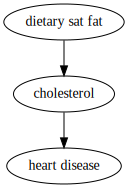

In [209]:
hd = CausalGraphicalModel(
    nodes=["dietary sat fat", "cholesterol", "heart disease"],
    edges=[
        ("dietary sat fat", "cholesterol"), 
        ("cholesterol", "heart disease"), 
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
hd.draw()

Intuitively we often think of causality in an as-if (or *counterfactual*) way: If I were to change one thing, how would it affect something else?  We can see that the graph in this example implies two possible interventions that one could make in order to affect heart disease. First, we could manipulate the level of dietary saturated fat; for example, we could perform a randomized controlled trial where we randomly assign people to eat either a high- or low-saturated fat diet.  Randomization plays the important role of equating (on average) any other variables that might affect the outcome.  We could also imagine performing a randomed trial where we manipulate cholesterol levels (e.g. through a drug).  In each case, we infer the presence of a causal relation on the basis of our ability to directly control or manipulate a relevant aspect of the system. 


## Causal vs. statistical language

"Correlation is not causation, but it sure is a hint." -- Edward Tufte

If we see a statistical relationship between two variables X and Y, what does that mean in terms of causality?  It could mean any of a number of different things (Glymour, 2006):

1. There are no causal relations between X and Y; the association arose by random fluctuation
2. X causes Y
3. Y causes X
4. The association is *confounded* - that is, a common third factor causes both X and Y
5. The association is *spurious*, due to conditioning on a common effect of X and Y (as we discuss more below).


In order to go from a question about causality to a question that we can assess using statistics, we need to look at the implications of the graphical structure of a causal model on the statistical relations between variables.  In particular, we will focus on *conditional indepdendence*: That is, for which set of variables can we infer that they should be statistically independent, after conditioning on some other variables.


### Assumptions of the graphical causal modeling approach

The causal modeling approach makes several important assumptions:

1. Causal Markov assumption: Every variable in a DAG is independent of all of its non-descendents, conditional on its parents. That is, any variable X is independent of any other variable Y conditioning on the direct causes of X, unless X is an ancestor of Y.
2. Faithfulness assumption: The statistical relationships in the data faithfully reflect the causal structure.  In particular, positive and negative causal effects do not perfectly cancel each other out.
3. Negligible randomness: We assume that any observed statistical relationships did not arise due to chance.

### d-separation

It turns out that a DAG directly implies a set of statistical independence relations between the variables in the graph.  A criterion known as *d-separation* was proposed by Pearl to allow us to identify these implies conditional independence relationships.  The basic idea is this (from Kline, 2016): A pair of variables X and Y is d-separated by another set of variables Z if and only if Z blocks every path from X to Y.

A pair of variables connected by a path in a DAG is d-separated by a set of other variables Z if either:

1. one of the non-colliders on the path is in Z, or 
2. there is a collider on the path, but neither the collider nor any of its descendants is in Z


Let's look at the three different ways in which a directed graph involving three nodes can be arranged, using simple examples.  

The first example is a *fork*:

Implied conditional Independence Relationship:  [('x3', 'x1', {'x2'})]


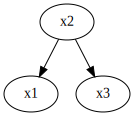

In [7]:
from causalgraphicalmodels.examples import fork, chain, collider

print("Implied conditional Independence Relationship: ", 
      fork.get_all_independence_relationships())
fork.draw()

In the fork, x1 and x3 are d-separated by x2 because the path between x1 and x3 includes the non-collider x2.  Thus, x1 and x3 become independent after conditioning on x2.  The path between x1 and x3 is known as a *back-door* path, because the path is a back door for spurious association between the variables to arise.

The second example is a *chain*:

Implied conditional Independence Relationship:  [('x3', 'x1', {'x2'})]


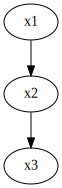

In [8]:
print("Implied conditional Independence Relationship: ", 
      chain.get_all_independence_relationships())
chain.draw()

In the chain, x1 and x3 are d-separated by x2 because the path between x1 and x3 includes the non-collider x2.  Thus, once again x1 and x3 become independent after conditioning on x2.

The third is example is an inverted fork with a *collider*.  

Implied conditional Independence Relationship:  [('x3', 'x1', set())]


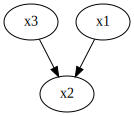

In [10]:
print("Implied conditional Independence Relationship: ", 
      collider.get_all_independence_relationships())
collider.draw()""

In this example, x1 and x3 are independent (unconditionally) because there is no path between them. However, they actually become *dependent* once we conditionalize on x2 (the node where the inputs collide).  This can give rise to some unintuitive phenomena, which go the names of "Berkson's paradox" or "conditioning on a common effect" (which we return to below).


We can use the d-separation criterion to automatically identify all of the pairwise independence relations in the sprinkler example:

In [182]:
sprinkler.get_all_independence_relationships()

[('rain', 'slippery', {'wet'}),
 ('rain', 'slippery', {'sprinkler', 'wet'}),
 ('rain', 'slippery', {'season', 'wet'}),
 ('rain', 'slippery', {'season', 'sprinkler', 'wet'}),
 ('rain', 'sprinkler', {'season'}),
 ('wet', 'season', {'rain', 'sprinkler'}),
 ('wet', 'season', {'rain', 'slippery', 'sprinkler'}),
 ('slippery', 'sprinkler', {'wet'}),
 ('slippery', 'sprinkler', {'rain', 'wet'}),
 ('slippery', 'sprinkler', {'season', 'wet'}),
 ('slippery', 'sprinkler', {'rain', 'season', 'wet'}),
 ('slippery', 'season', {'wet'}),
 ('slippery', 'season', {'rain', 'sprinkler'}),
 ('slippery', 'season', {'sprinkler', 'wet'}),
 ('slippery', 'season', {'rain', 'wet'}),
 ('slippery', 'season', {'rain', 'sprinkler', 'wet'})]

These implied conditional independence relationships provide one way of testing the fit of a model, because they imply that particular partial correlations in the data should tend to zero (or "vanish") (e.g. $\rho_{rain, slippery|wet}$).  This approach is used the in [TETRAD software ](http://www.phil.cmu.edu/tetrad/) to search for causal structure in data; we will not discuss causal discovery in this class, but interested readers should read [Causation, Prediction, and Search by Spirtes et al.](https://mitpress.mit.edu/books/causation-prediction-and-search-second-edition).

Note that in an important sense, it is the *missing* edges in the graph that are in some ways most important, because they reflect strong claims about an absolute lack of causal influence between the nodes.  For this reason, when generating a causal graph, Pearl (2009) suggests that one starts with bidrectional arrows between each pair of nodes, which "should be deleted only by well-motivated justifications, such as the unlikely existence of a common cause for the two variables and the unlikely existence of selection bias. Although we can never be cognizant of all the factors that may affect our variables, substantive knowledge sometimes permits us to state that the influence of a possible common factor is not likely to be significant." (Pearl, 2009, p. 163).

## Markov equivalence

In some cases different graphs can have the same statistical implications; they are said to comprise a *Markov equivalence class*.  For example, take the following three graphs:


![](me1.png)  |  ![](me2.png) |  ![](me3.png)

All of these have the same set of implied conditional independencies:

`('X', 'W', {'Z'}), 
('X', 'W', {'Z', 'Y'}), 
('X', 'Y', {'Z'}), 
('X', 'Y', {'Z', 'W'})`

This means that we could not distinguish between these models based on the statistical relations between the variables, regardless of the amount of data; if we tried to do so we would be wasting our time.  As in this example, these kinds of equivalence classes will generally reflect cases where the direction of particular edges varies between the members of the equivalence class.

## Unobserved causes

In the former examples, all of the variables in our graphs were observable, but in many cases (including those of greatest interest for SEM), there are variables that are unobservable, or *latent* in SEM language.  In order to be considered a proper causal graph, the graph must also include any known but unobserved causes.  If we don't include these, then the causal assumptions fail.

For example, let's go back to our example above regarding the relationship between saturated fat intake and heart disease:

[('dietary sat fat', 'heart disease', {'cholesterol'})]


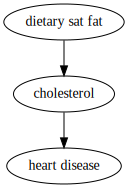

In [210]:

print(hd.get_all_independence_relationships())
hd.draw()


We interpret this to say that if we could hold cholesterol constant (e.g. using a drug that controlled it), then diet and heart diseease would become conditionally independent.  However, it is generally known that people who take supposedly "healthy" actions in one domain will often take those actions in other domains as well; this is know as the ["healthy user bias"](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3077477/). For example, people who eat a "healthy" diet will also be more likely to exercise, which can improve cardiovascular health, either by affecting cholesterol directly or by other mechanisms.  There are also likely to be other factors that affect both healthy user bias and heart disease (e.g. socioeconomic status).  Thus, the true causal graph probably looks more like this:

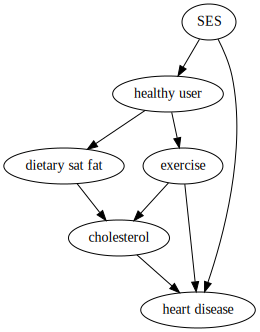

In [217]:
hd2 = CausalGraphicalModel(
    nodes=["dietary sat fat", "cholesterol", "heart disease", "healthy user", "exercise", "SES"],
    edges=[
        ("dietary sat fat", "cholesterol"), 
        ("cholesterol", "heart disease"), 
        ("healthy user", "dietary sat fat"),
        ("exercise", "cholesterol"),
        ("healthy user", "exercise"),
        ("exercise", "heart disease"),
        ("SES", "healthy user"),
        ("SES", "heart disease")
    ]
)

hd2.draw()


If we don't have a measurement of healthy user bias (which we generally don't), then healthy user status must be treated as an unobserved variable. 

## Confounding

Another way that we might describe the situation above is that the relationship between dietary fat intake and heart disease is *confounded*.  In the language of graphical causal modeling, we would say there is a *back-door path* that connects these two variables. For this graph we can identify the back-door paths automatically:

In [220]:
hd2.get_all_backdoor_paths('dietary sat fat', 'heart disease')

[['dietary sat fat',
  'healthy user',
  'exercise',
  'cholesterol',
  'heart disease'],
 ['dietary sat fat', 'healthy user', 'exercise', 'heart disease'],
 ['dietary sat fat', 'healthy user', 'SES', 'heart disease']]

One useful feature of causal modeling is that we can also identify which other variables can be conrtrolled in order to eliminate any potential confounding, by identifying those sets that block all of the back-door paths between our two variables of interest:

In [221]:
hd2.get_all_backdoor_adjustment_sets('dietary sat fat', 'heart disease')

frozenset({frozenset({'healthy user'}),
           frozenset({'exercise', 'healthy user'}),
           frozenset({'SES', 'exercise'}),
           frozenset({'SES', 'healthy user'}),
           frozenset({'SES', 'exercise', 'healthy user'})})

Thus, *assuming that this causal model is correct and complete*, we can identify the total causal effect of dietary saturated fat intake on heart disease if we control for any of the sets of variables identifed as an *adjustment set*.

## Framing simple regression as a causal model

Although results from regression analyses are often framed in terms of causal language, the regression model itself is inherently agnostic to the direction of influence between the different variables.  Let's take a particular regression equation:

$$
y_i = \alpha_y + \beta_{yx} * x_i + \epsilon_{yi}
$$

where $\alpha$ is the intercept and $\beta_{yx}$ is the slope for y against x.  We could equivalently write this as:

$$
x_i = \alpha_x + \beta_{xy} * y_i + \epsilon_{xi}
$$

where:

$$
\alpha_x = \frac{-\beta_{yx}}{\alpha_y}, 
$$

$$
\beta_{xy} = \frac{1}{\beta_{yx}}, 
$$

and

$$
\epsilon_{xi} = \frac{\epsilon_{yi}}{-\beta_{yx}}
$$


Thus, from the standpoint of regression, it is perfectly legitimate to use either the X or Y variable as the predictor, since the goal is simply to predict the value of one variable conditional on the value of another.

But now think about this from the standpoint of a *structural model*.  The first equation can be drawn as follows:

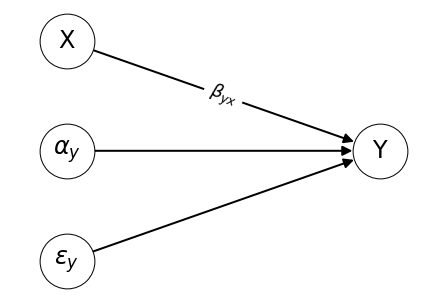

In [289]:
G = nx.DiGraph()
G.add_edge('X', 'Y')
G.add_edge('e', 'Y')
G.add_edge('a', 'Y')
pos = {'X':[0, 1], 'e':[0, 0], 'Y':[0.5, 0.5], 'a':[0, 0.5]}
nx.draw(G, pos, node_size=3000, node_color='white', edgecolors='black', width=2, arrowsize=20)
edge_labels={('X', 'Y'): r'$\beta_{yx}$'}
node_labels={i:i for i in G.nodes}
node_labels['e'] = r'$\epsilon_y$'
node_labels['a'] = r'$\alpha_y$'
_ = nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=24)
_ = nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=18)


The second equation would be drawn as:

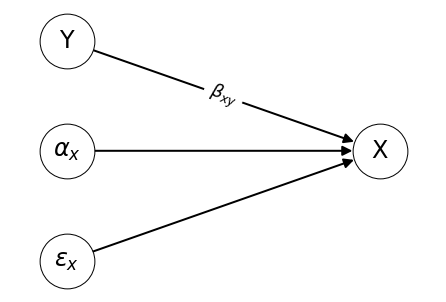

In [290]:
G = nx.DiGraph()
G.add_edge('Y', 'X')
G.add_edge('e', 'X')
G.add_edge('a', 'X')
pos = {'Y':[0, 1], 'e':[0, 0], 'X':[0.5, 0.5], 'a':[0, 0.5]}
nx.draw(G, pos, node_size=3000, node_color='white', edgecolors='black', width=2, arrowsize=20)
edge_labels={('X', 'Y'): r'$\beta_{xy}$'}
node_labels={i:i for i in G.nodes}
node_labels['e'] = r'$\epsilon_x$'
node_labels['a'] = r'$\alpha_x$'
_ = nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=24)
_ = nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=18)


It's clear from looking at these two causal graphs that they make very different predictions; in particular, whereas the first graph implies that manipulating X should have an effect on Y, the second graph would imply that changing the value of X should have no effect on the value of Y.

The causal model requires several assumptions ([Bollen & Pearl, 2012](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2343821)):

1. Linearity: the effect of a unit change in X on Y is the same regardless of the value of X
2. Exclusion: if we hold X constant, then changes to other variables in the model (e.g. variables Z that affect the value of X) will not have any effect on Y
3. Homogeneity: the causal effect $\beta_{yx}$ is the same for all units in the population.

Thus, a causal model can be thought of as one or more regression equations along with a set of causal assumptions.

# Berkson's paradox

We saw above that if we condition on a collider (i.e. a common effect), we induce an association between initially independent variables.  Think about the sprinkler example for a moment. If we know that either the sprinkler or rain can cause the sidewalk to be wet, then if we know that it's is wet and that it was raining, then it becomes less likely that the sprinkler caused the wetness; in the langauge of Bayesian reasoning, we have "explained away" the wetness once we know that it has rained.


Berkson's paradox has important consequences in the context of regression analysis, where including a common effect of the x and y variables as a regressor in the model can introduce spurious relationships.  To see this in action, let's set up a (somewhat contrived) situation that can help us understand how conditioning on a collider (or the child of a collider) can affect regression parameter estimates.  Here we will create a simulated example of conditioning on a collider to see how it affects regression parameters.  

In [183]:
npts = 100
np.random.seed(67895)
colliderDf = pd.DataFrame({'x1': np.random.randn(npts),
                           'x3': np.random.randn(npts)})
colliderDf['x2'] = colliderDf.mean(1) + np.random.randn(npts)*.1

colliderDf.corr()

,x1,x3,x2
x1,1.000000,0.000601,0.726513
x3,0.000601,1.000000,0.675513
x2,0.726513,0.675513,1.000000


Let's say that we run a linear regression for x1 vs x3:

In [184]:
import statsmodels.api as sm
model = sm.OLS(colliderDf['x1'], colliderDf['x3'])
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     x1   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):             -0.010
Method:                 Least Squares   F-statistic:                            0.05556
Date:                Fri, 03 Apr 2020   Prob (F-statistic):                       0.814
Time:                        08:44:30   Log-Likelihood:                         -149.31
No. Observations:                 100   AIC:                                      300.6
Df Residuals:                      99   BIC:                                      303.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x3             0.0253      0.107      0.236      0.814      -0.188       0.238
==============================================================================
Omnibus:                        5.563   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.062   Jarque-Bera (JB):                8.391
Skew:                           0.061   Prob(JB):                       0.0151
Kurtosis:                       4.414   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Here we see that there is no significant relationship between the two variables, but the coefficient for x3 is slightly positive.  However, if we add the collider x2 to the model:

In [185]:
model2 = sm.OLS(colliderDf['x1'], colliderDf[['x3', 'x2']])
result2 = model2.fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     x1   R-squared (uncentered):                   0.970
Model:                            OLS   Adj. R-squared (uncentered):              0.969
Method:                 Least Squares   F-statistic:                              1589.
Date:                Fri, 03 Apr 2020   Prob (F-statistic):                    2.11e-75
Time:                        08:44:32   Log-Likelihood:                          26.116
No. Observations:                 100   AIC:                                     -48.23
Df Residuals:                      98   BIC:                                     -43.02
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x3            -0.9745      0.026    -37.827      0.000      -1.026      -0.923
x2             1.9659      0.035     56.349      0.000       1.897       2.035
==============================================================================
Omnibus:                        0.937   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.626   Jarque-Bera (JB):                1.038
Skew:                          -0.207   Prob(JB):                        0.595
Kurtosis:                       2.721   Cond. No.                         2.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now we see that the effect of x3 is highly significant in the negative direction! This is because when one conditionalizes on the collider, the only remaining variance must necessarily move in the opposite direction.  This example shows how insights from graphical causal models are useful even if one doesn't wish to explicitly test causal hypotheses.

## discuss selection bias?

## SEM as a causal model

[Pearl (2012)](https://ftp.cs.ucla.edu/pub/stat_ser/r370.pdf) lays out the logic of structural equation modeling (SEM) in the context of graphical causal models.

The inputs to the model are:

1. A set $A$ of causal assumptions (justified on scientific grounds) that are encoded in a model $M_A$ expressed as a directed graph.
2. A set $Q$ of questions concerning causal relations between the variables in the model --- e.g. "What is the effect of treatment X on outcome Y?"
3. A set $D$ of data (experimental or observational) presumably generated by a process consistent with assumptions $A$.

The outputs from the process of modeling are:

1. A set $A*$ of statements regarding the logical implications of $A$, separate from the data, such as the conditional independences implicated by the graph.
2. A set $C$ of data-based claims regarding the magnitudes or likelihoods of the questions in $Q$ given the data $D$ and assumptions $A$.
3. A set $T$ of testable statistical implications of $A$, such as the predicted vanishing of particular partial correlations that is implied by conditional independence relationships.

Note that SEM can never provide evidence in favor of the causal assumptions; those serve somewhat like the null hypothesis in standard statistical testing. What it can do is allow us to (sometimes) ask questions out the specific causal effects in the model, and therefore disconfirm particular claims (e.g. by showing that a particular claimed causal effect is not different from zero).  They can also provide us estimates of the magnitude of the causal effect, which could be useful for guiding our behavior (such as treatment or policy intervention).

As Bollen and Pearl (2012) say:

>Lest there be any doubt:
SEM does not aim to establish causal relations from associations alone.
Perhaps the best way to make this point clear is to state formally and unambiguously
what SEM does aim to establish. SEM is an inference engine that takes in two inputs, qualitative causal assumptions and empirical data, and derives two logical consequences of these inputs: quantitative causal conclusions and statistical measures of fit for the testable implications of the assumptions. Failure to fit the data casts doubt on the strong causal assumptions of zero coefficients or zero covariances and guides the researcher to diagnose, or repair the structural misspecifications. Fitting the data does not “prove” the causal assumptions, but it makes them tentatively more plausible. Any such positive results need to be replicated and to withstand the criticisms of researchers who suggest other models for the same data.



## The do-calculus

When we use causal language, 
The first two assumptions can be written in terms of the do-calculus:

$E(Y|do(x), do(z)) = \alpha_y + \beta_{yx}*x$



## counterfactuals

- "surgical" interpretation

## Potential outcomes framework

## Identifying causal effects

- back door criterion

- single door criterion

- confounding


## Mediation models

Causal graph interpretation:

Direct effect: (as a do-expression)

Indirect effect: 

total effect



### Challenges for interpreting mediation (Glymour, 2008)

